In [17]:
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from comet_ml import Experiment
from comet_ml.integration.sklearn import log_model

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.calibration import calibration_curve

import pickle

from dotenv import load_dotenv
load_dotenv()

COMET_API_KEY = os.getenv('COMET_API_KEY')

In [18]:
def pre_processing(df,fill_nan_mod = False,drop_nan = False,oneHot = False):
    
    df_val = df[(df['eventType'] == 'Shot') | (df['eventType'] == 'Goal')]
    X = df_val[ ['shotType', 'distance' ,'angle','isGoal','emptyNet','eventPeriod','x','y','game_time',\
         'timeFromLastEvent','prevEventType', 'distFromPrev','prevEventX','prevEventY', \
         'isRebound','changeInAngle', 'speed']  ]
    X = X.dropna(subset=['shotType']).reset_index(drop=True)

    if drop_nan == True:
        X = X.dropna()
        X = X.reset_index(drop = True)

    if fill_nan_mod == True:
        
        for column in X.columns:
            
            mode_value = X[column].mode()[0]
            
            X[column] = X[column].fillna(mode_value)


    if oneHot == True:
        ohe = OneHotEncoder()
        
        # Assuming X is your input DataFrame and 'shotType' and 'prevEventType' are the columns to be encoded.
        encoded_values = ohe.fit_transform(X[['shotType', 'prevEventType']])
        
        # Convert the sparse matrix to a dense array
        encoded_values_dense = encoded_values.toarray()
        
        # Now, create the DataFrame with the correct number of column names
        df_encoded = pd.DataFrame(encoded_values_dense, columns=ohe.get_feature_names_out(['shotType', 'prevEventType']))
        X = pd.concat([X.drop(['shotType', 'prevEventType'], axis=1), df_encoded], axis=1)

    return X

In [19]:
def combine_df(path_train_list,oneHot = False):
    if oneHot == True:
        df = pd.read_csv(path_train_list[0])
        df = pre_processing(df,oneHot = True)
        for i in range(1,len(path_train_list)):
            df_temp = pd.read_csv(path_train_list[i])
            df_temp = pre_processing(df_temp,oneHot = True)
            df = pd.concat([df,df_temp])
        df = df.reset_index(drop = True)
    if oneHot == False:
        df = pd.read_csv(path_train_list[0])
        df = pre_processing(df)
        for i in range(1,len(path_train_list)):
            df_temp = pd.read_csv(path_train_list[i])
            df_temp = pre_processing(df_temp)
            df = pd.concat([df,df_temp])
        df = df.reset_index(drop = True)
    return df

## Train and Validation split

- Here, we will use season `{20162017, 20172018, 20182019}` in training and `{20192020}` for validation.

In [20]:
path_train_list = ['./data_after_fe2/20162017_clean.csv','./data_after_fe2/20172018_clean.csv',\
                  './data_after_fe2/20182019_clean.csv']
path_valid_list = ['./data_after_fe2/20192020_clean.csv']

df_train = combine_df(path_train_list)
df_valid = combine_df(path_valid_list)

In [21]:
cleaned_df_train = df_train[(~df_train.distance.isna()) & (~df_train.speed.isna())]
cleaned_df_train = cleaned_df_train[cleaned_df_train['distance']!='shoot out']

cleaned_df_valid = df_valid[(~df_valid.distance.isna()) & (~df_valid.speed.isna())]
cleaned_df_valid = cleaned_df_valid[cleaned_df_valid['distance']!='shoot out']

In [22]:
def plot_roc_curve(model, X_val, y_val,title, experiment=None):
    
    fpr, tpr, thresholds = roc_curve( y_val, model.predict_proba(X_val)[:,1] )
    
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2,label='random baseline', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    plt.show()

In [23]:
def plot_goal_ratio(model, X_val, y_val, title, experiment=None):
    '''
    plot the graph of goal ratio
    input: model - the binary classification model
           X_val - the validation data
           y_val - the real labels of validation data
    '''
    bins = list(np.arange(0, 105, 5))
    bin_centers = list(np.arange(2.5, 100, 5.0))

    pred_prob = model.predict_proba(X_val)
    pred = model.predict(X_val)

    df_prob = pd.DataFrame({
        'goal_pred': pred,
        'goal': y_val.reset_index(drop=True),
        'goal_prob': pred_prob[:, 1] * 100
    })

    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()

    df_prob['percentile'] = df_prob['goal_prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels=bin_centers)

    df_prob_binned = df_prob[['goal_perc_bins', 'shot', 'goal']].groupby(['goal_perc_bins'],
                                                                         observed=False).sum().reset_index()

    df_prob_binned['goal_rate'] = (df_prob_binned['goal'] / df_prob_binned['shot'])
    df_prob_binned['goal_cum'] = (df_prob_binned['goal'] / sum_goal)
    df_prob_binned['goal_cumsum'] = 1 - df_prob_binned['goal_cum'].cumsum()

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.title(title)
    sns.lineplot(x='goal_perc_bins', y='goal_rate', data=df_prob_binned, legend=False, linewidth=2.5)
    plt.xlabel('Shot Probability Model Percentile')
    plt.ylabel('Goals / (Shots + Goals)')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.xticks(np.arange(0, 120, 20))
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    plt.show()

In [24]:
def plot_cumu_goal(model, X_val, y_val, title, experiment=None):
    bins = list(np.arange(0, 105, 5))
    bin_centers = list(np.arange(2.5, 100, 5.0))

    pred_prob = model.predict_proba(X_val)
    pred = model.predict(X_val)

    df_prob = pd.DataFrame({
        'goal_pred': pred,
        'goal': y_val.reset_index(drop=True),
        'goal_prob': pred_prob[:, 1] * 100
    })

    df_prob['shot'] = 1
    sum_goal = df_prob['goal'].sum()

    df_prob['percentile'] = df_prob['goal_prob'].rank(pct=True) * 100
    df_prob['goal_perc_bins'] = pd.cut(df_prob['percentile'], bins, labels=bin_centers)

    df_prob_binned = df_prob[['goal_perc_bins', 'shot', 'goal']].groupby(['goal_perc_bins'],
                                                                         observed=False).sum().reset_index()

    df_prob_binned['goal_rate'] = (df_prob_binned['goal'] / df_prob_binned['shot'])
    df_prob_binned['goal_cum'] = (df_prob_binned['goal'] / sum_goal)
    df_prob_binned['goal_cumsum'] = 1 - df_prob_binned['goal_cum'].cumsum()
    fig = plt.figure(figsize=(10, 5))
    plt.title(title)
    ax = sns.lineplot(x='goal_perc_bins', y='goal_cumsum', data=df_prob_binned, legend=False, linewidth=2.5)
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    ax.set_xlim(left=101, right=-1)
    ax.set_ylim(bottom=0, top=1)
    plt.xticks(np.arange(0, 120, 20))
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    fig.show()

In [25]:
def plot_calib(model, X_val, y_val, title, experiment=None):
    pred_prob = model.predict_proba(X_val)
    pred = model.predict(X_val)

    pred_prob = model.predict_proba(X_val)
    pred = model.predict(X_val)

    df_prob = pd.DataFrame({
        'goal_pred': pred,
        'goal': y_val.reset_index(drop=True),
        'goal_prob': pred_prob[:, 1] * 100
    })

    df_prob['shot'] = 1

    fig = plt.figure(figsize=(10, 6))
    plt.title(title)
    prob_true_da, prob_pred_da = calibration_curve(df_prob['goal'], df_prob['goal_prob'] / 100, n_bins=20)
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(prob_pred_da, prob_true_da, "s-", label='Using Distance and angle')
    plt.xlabel('shot probability model percentile')
    plt.ylabel('proportion')
    plt.legend(loc="upper left")
    plt.xticks(np.arange(0, 1.2, 0.2))
    plt.yticks(np.arange(0, 1.2, 0.2))
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    fig.show()

In [26]:
def plot_cmap(y_val,y_pred,title,experiment=None):
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    if experiment:
        experiment.log_figure(figure_name=title, step=None)
    plt.show()

In [27]:
def replace_inf(df, feature):
    max = np.sort(df[feature].unique())[-3]
    return df[feature].replace(np.inf,max)

In [32]:
def run_experiment(name, model, X_train, y_train, X_test, y_test, ckpt_path="../../src/models/"):
    experiment = Experiment(
      api_key=COMET_API_KEY,
      project_name="baselines",
      workspace="ift6758-milestone2-udem"
    )
    
    model.fit(X_train,y_train)
    file_name = name + '.pkl'
    with open(os.path.join(ckpt_path, file_name), 'wb') as file:  
        pickle.dump(model, file)    
    y_pred = model.predict(X_test)
    
    test_acc = metrics.accuracy_score(y_test, y_pred)
    print(f"Test accuracy :{test_acc}")
    plot_roc_curve(model, X_test, y_test,title="RandomForest AUROC", experiment=experiment)
    plot_goal_ratio(model, X_test, y_test, title="RandomForest Goal Rate", experiment=experiment)
    plot_cumu_goal(model, X_test, y_test, title="RandomForest Goal Cumulative Proportion", experiment=experiment)
    plot_calib(model, X_test, y_test, title="RandomForest Calibration Curve", experiment=experiment)
    plot_cmap(y_test,y_pred,title="RandomForest Confusion Matrix",experiment=experiment)
    
    experiment.log_metric("Test accuracy", test_acc)
    experiment.log_model(name, os.path.join(ckpt_path, file_name))
    experiment.end()

In [33]:
model = RandomForestClassifier()

In [34]:
X_train = cleaned_df_train[['distance', 'angle', 'game_time', 'speed']]
new_speed_train = replace_inf(X_train, "speed")
X_train.speed = new_speed_train
y_train = cleaned_df_train['isGoal']


X_valid = cleaned_df_valid[['distance', 'angle', 'game_time', 'speed']]
new_speed_valid = replace_inf(X_valid, "speed")
X_valid.speed = new_speed_valid 
y_valid = cleaned_df_valid['isGoal']


/var/folders/l6/bdpfj8c928vfm_9q6gky77c40000gn/T/ipykernel_2762/1160407106.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.speed = new_speed_train
/var/folders/l6/bdpfj8c928vfm_9q6gky77c40000gn/T/ipykernel_2762/1160407106.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid.speed = new_speed_valid


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/c979eb4a34104da1b3ad53b99a059512
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : None
COMET INFO:     criterion                : gini
COMET INFO:     max_depth                : None
COMET INFO:     max_features             : sqrt
COMET INFO:     max_leaf_nodes           : None
COMET INFO:     max_samples              : None
COMET INFO:     min_impurity_decrease    : 0.0
COMET INFO:     min_samples_leaf         : 1
COMET INFO:     min_samples_split        : 2
COMET INFO:     min_wei

Test accuracy :0.8995152683284668


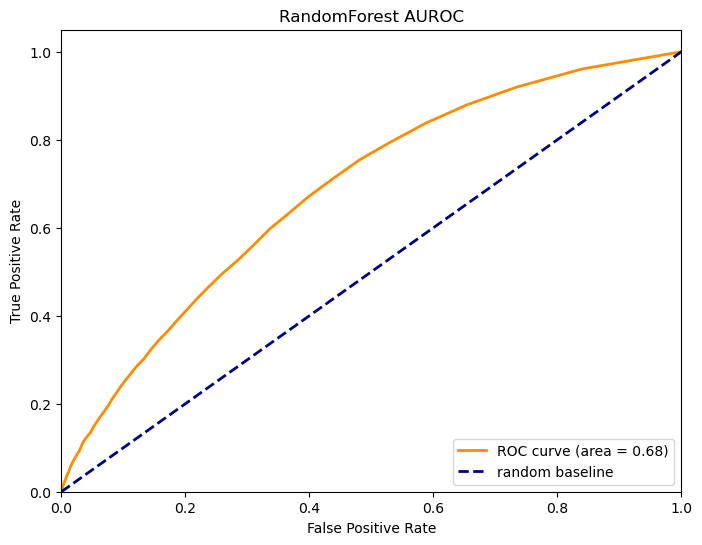

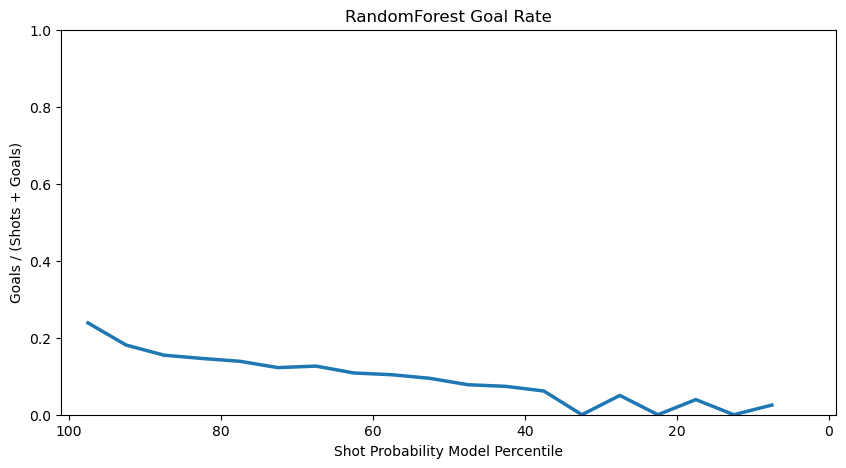

/var/folders/l6/bdpfj8c928vfm_9q6gky77c40000gn/T/ipykernel_2762/1243858168.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/l6/bdpfj8c928vfm_9q6gky77c40000gn/T/ipykernel_2762/395461688.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


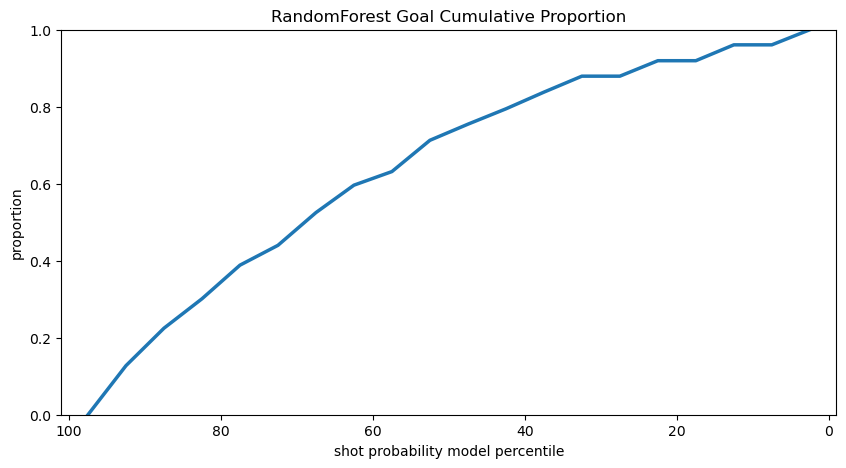

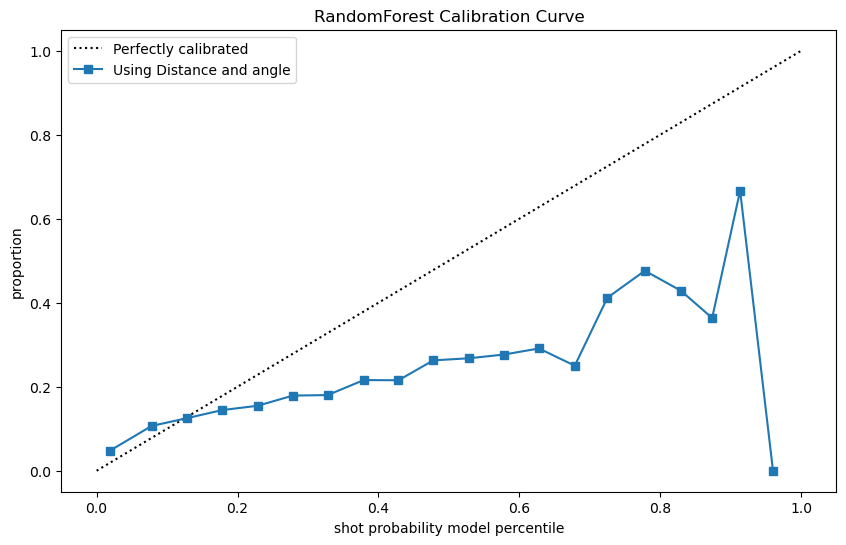

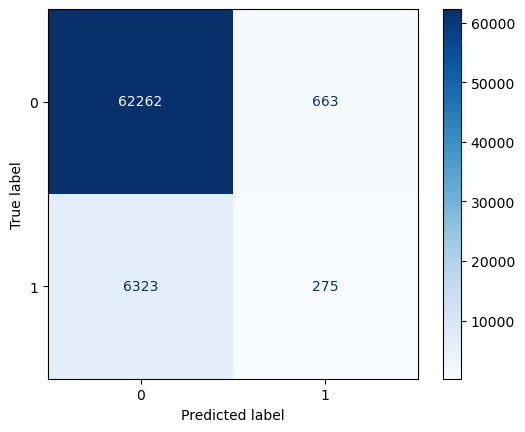

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/ift6758-milestone2-udem/baselines/55dd88af06be450b8a3db45527198472
COMET INFO:   Metrics:
COMET INFO:     Test accuracy : 0.8995152683284668
COMET INFO:   Parameters:
COMET INFO:     bootstrap                : True
COMET INFO:     ccp_alpha                : 0.0
COMET INFO:     class_weight             : None
COMET INFO:     criterion                : gini
COMET INFO:     max_depth                : None
COMET INFO:     max_features             : sqrt
COMET INFO:     max_leaf_nodes           : None
COMET INFO:     max_samples              : None
COMET INFO:     min_impurity_decrease    : 0.0
COMET INFO:     min_samples_leaf       

In [35]:
run_experiment("RandomForest_1", model, X_train, y_train, X_valid, y_valid, )